# Find Lanes


In [1]:
import os
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import plotly.graph_objects as go
import utm

repo_root = Path(os.getcwd()).parent

while not (repo_root / ".git").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

# set the pandas plotting backend to plotly
pd.options.plotting.backend = "plotly"


## Load Image


In [2]:
# import cv2
# import matplotlib.pyplot as plt


# image = cv2.imread(str(repo_root / "lane-finder-points.png"))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(15,15))
# plt.imshow(image)
# plt.axis('off')
# plt.show()

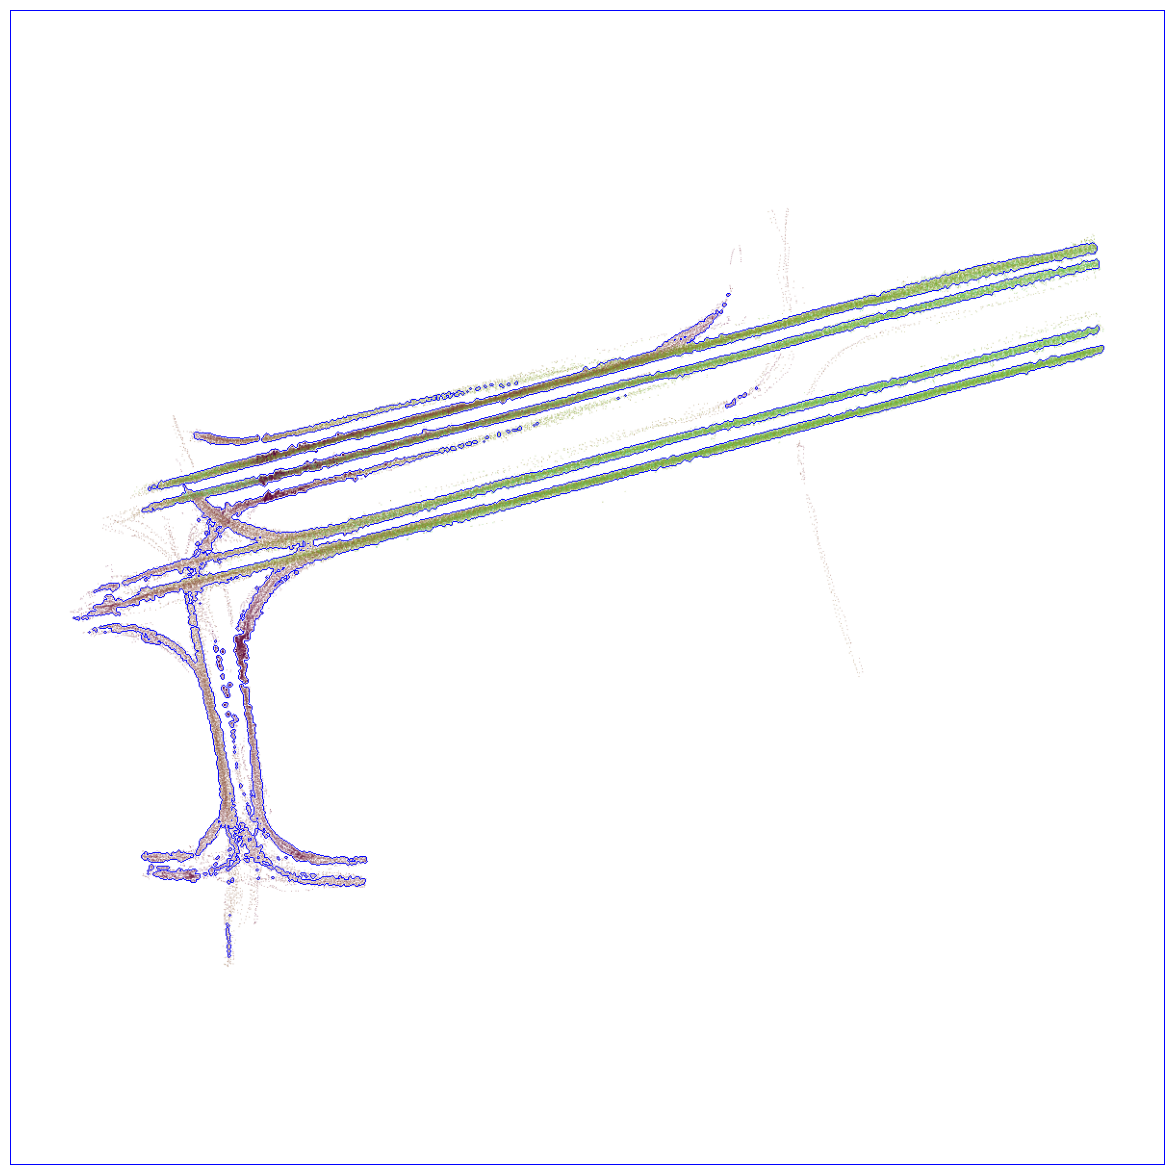

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # canny = cv2.Canny(blur, 50, 150)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # find the contours from the thresholded image
    contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return th3, contours
    
image = cv2.imread(str(repo_root / "lane-finder.png"))
lane_image = np.copy(image)
canny_img, contours = canny(lane_image) 


fig = plt.figure(figsize=(15,15))
# plt.imshow(canny_img)

# show the contours on the image
img = cv2.drawContours(lane_image, contours, -1, (0, 0, 255), 1)
plt.imshow(img)

# turn of the axis
plt.axis('off')

plt.show()

In [4]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return line_image

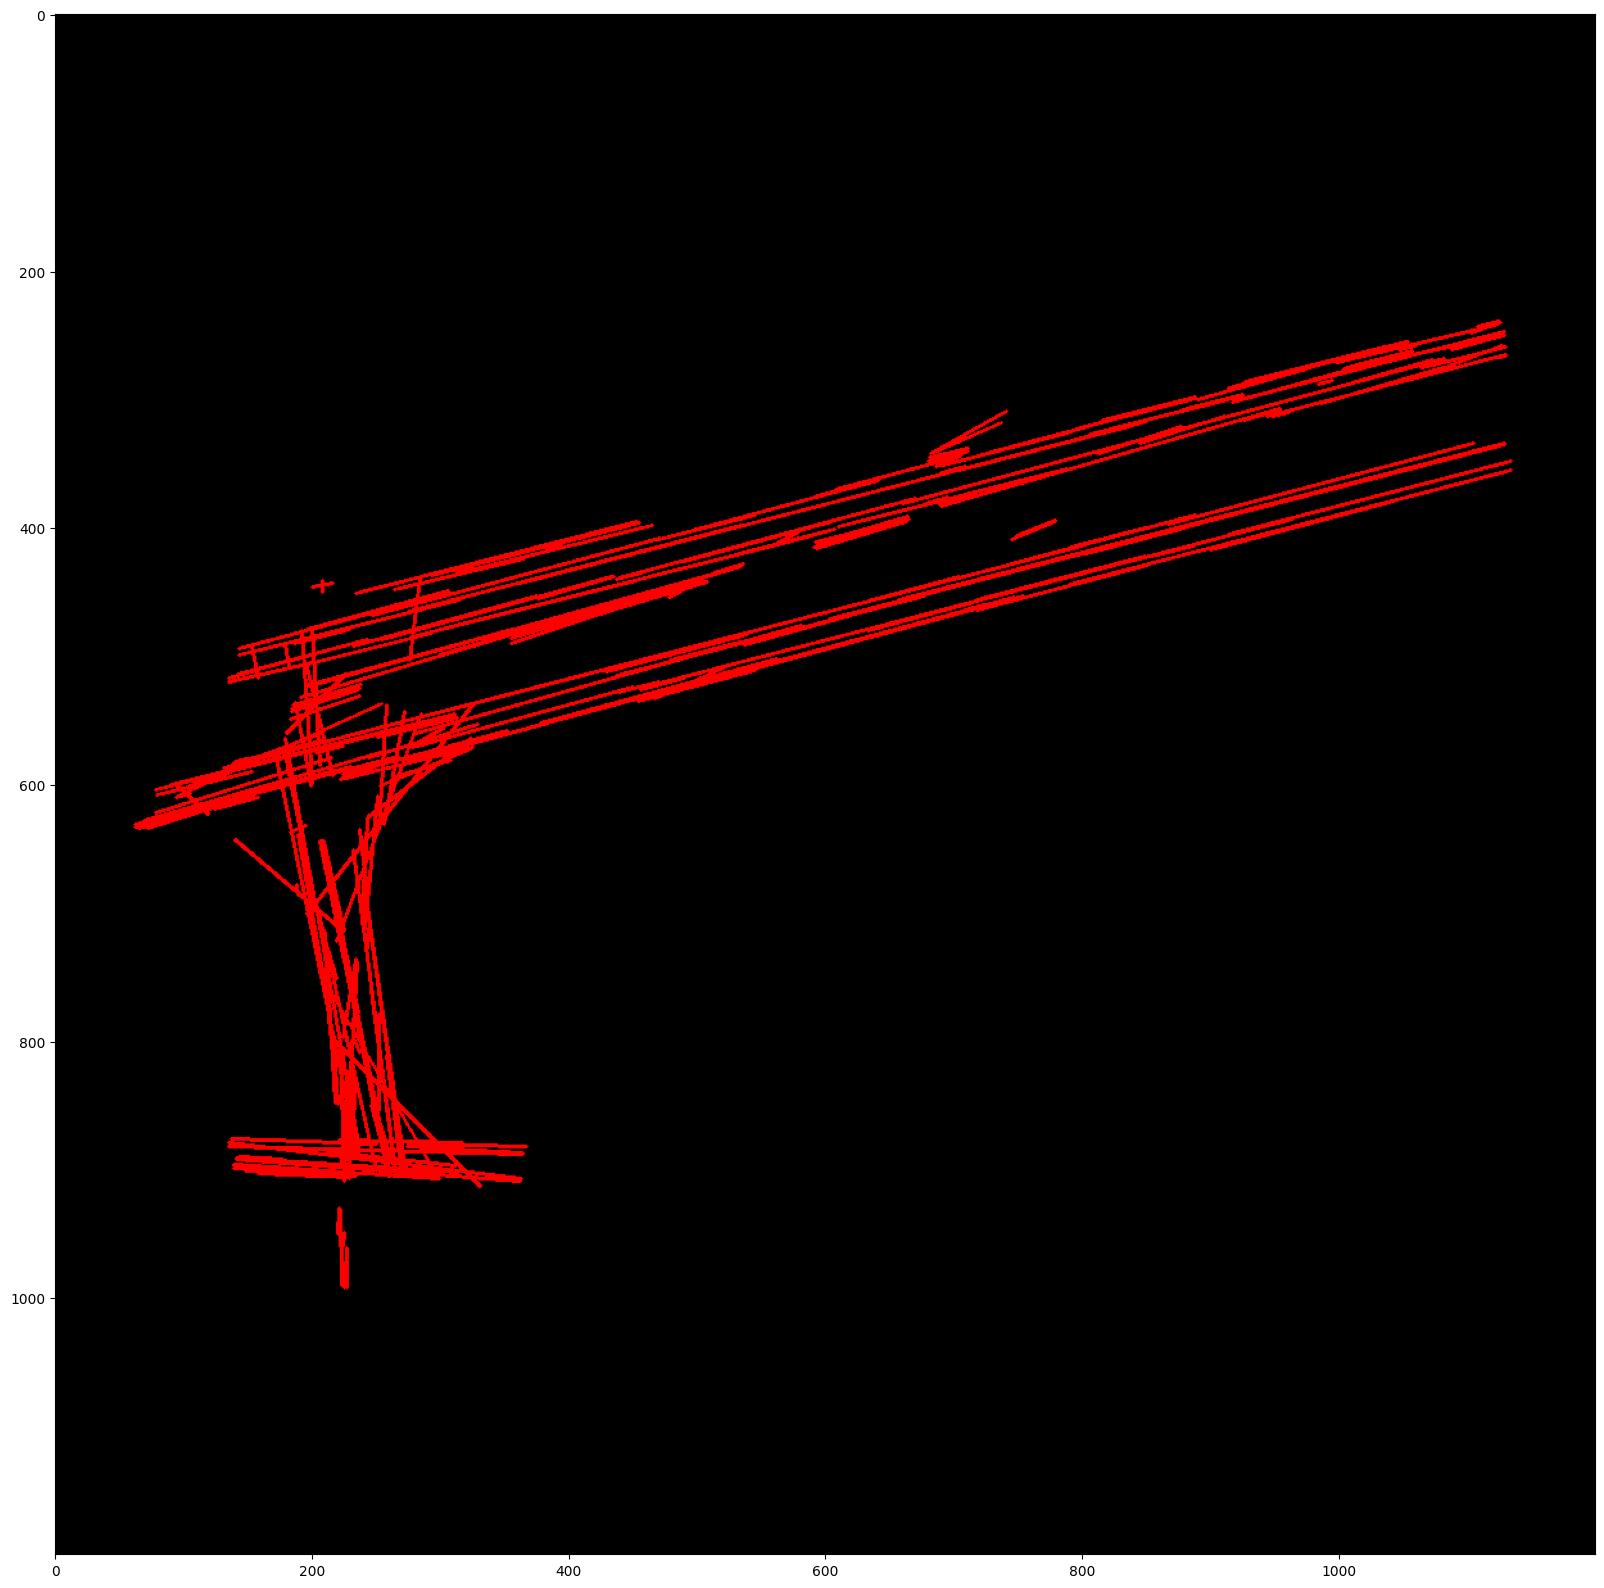

In [26]:
lines = cv2.HoughLinesP(canny_img, 1, np.pi/360, 50, np.array([]), minLineLength=5, maxLineGap=20)

# averaged_lines = average_slope_intercept(lane_image, lines)
lines = [line[0] for line in lines]
line_image = display_lines(lane_image, lines)
# combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

# show image 20, 20
fig = plt.figure(figsize=(20,20))
plt.imshow(line_image)

### Just Look at One TL


In [28]:
interest_df = df.filter(pl.col("ip") == "10.160.7.137")


In [29]:
f.h3_resolution = 14

interest_df = interest_df.pipe(f.radar_to_h3)


function: radar_to_h3 took: 0.8097658157348633 seconds


#### Plot the x/y data in a scatter plot


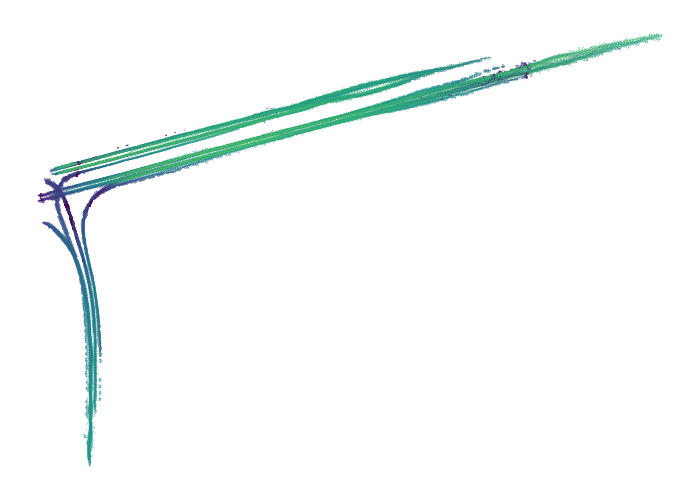

In [35]:
fig = go.Figure()

_df = interest_df.with_columns(
    [
        pl.col("object_id").n_unique().over("h3").alias("n_objects"),
    ]
).filter(pl.col("n_objects") > 10)

fig.add_trace(
    go.Scatter(
        x=_df["utm_x"],
        y=_df["utm_y"],
        mode="markers",
        marker=dict(
            size=1,
            color=_df["f32_velocityInDir_mps"],
            colorscale="Viridis",
            # set the alpha to 0.5
            opacity=0.5,
        )
    )
)

# make the image square
fig.update_layout(
    autosize=False,
    # width=800,
    # height=800,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    ),
)
# plot with a white background and no x and y axis
fig.update_layout(
    plot_bgcolor="white",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    xaxis_visible=False,
    yaxis_visible=False,
)

# make figure span the whole figure
fig.update_layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0,
    )
)

# write to a huge figure
fig.write_image(
    repo_root / "lane-finder.png",
    width=2400,
    height=2400,
)
# SHOW AS image
fig.show(renderer="png")


#### Compress Each Trajectory into it's H3 representation


New idea:

- Compress each trajectory into h3 representation
- The a trajectory is 5 steps of h3
- Use the center coords of h3 to cluster the trajectories (using euclidean distance)
- The distance can be precomputed using h3 center -> utm x,y ->
-


In [6]:
h3_obj_ids = (
    interest_df
    # every 3 hexagons, create a new object id
    .groupby_dynamic("epoch_time", every="60s", by="object_id")
    .agg([pl.col("h3")])
    .with_row_count()
    .with_columns(
        [(pl.col("object_id") + "-" + pl.col("row_nr").cast(str)).alias("object_id")]
    )
    .drop(["row_nr", "epoch_time"])
    .explode("h3")
    .with_columns(
        [
            pl.col("object_id").count().over("h3").alias("count"),
        ]
    )
    .filter(pl.col("count") > 2)
    .drop("count")
)


h3_dataframe = (
    h3_obj_ids.pivot(
        values="h3",
        index="object_id",
        columns="h3",
        aggregate_function="count",
    )
    .fill_null(0)
    .to_pandas()
)


In [7]:
h3s = h3_dataframe.set_index(
    "object_id",
).columns.to_list()


In [8]:
# do tsne on the h3 dataframe

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1, metric="cosine")

tsne_results = tsne.fit_transform(h3_dataframe.drop(columns="object_id").to_numpy())

# merge the tsne results with the original dataframe
tsne_df = pd.DataFrame(tsne_results, columns=["tsne_x", "tsne_y"])

tsne_df = pd.concat([h3_dataframe["object_id"], tsne_df], axis=1)

# plot the tsne results
fig = go.Figure()


_plot_df = tsne_df.sample(1000)

fig.add_trace(
    go.Scatter(
        x=_plot_df["tsne_x"],
        y=_plot_df["tsne_y"],
        mode="markers",
    )
)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2247 samples in 0.011s...
[t-SNE] Computed neighbors for 2247 samples in 0.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2247
[t-SNE] Computed conditional probabilities for sample 2000 / 2247
[t-SNE] Computed conditional probabilities for sample 2247 / 2247
[t-SNE] Mean sigma: 0.137527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.077209
[t-SNE] KL divergence after 1000 iterations: 0.836672


### Clustering on Vehicle H3 Vectors


In [9]:
## Cluster using DBSCAN
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.spatial import ConvexHull
import numpy as np
import h3


dbscan = DBSCAN(eps=0.3, min_samples=5, metric="cosine")
dbscan.fit(h3_dataframe.drop(columns="object_id"))
tsne_df["cluster"] = dbscan.labels_

# create a dictionary of included hexagons

cluster_h3s = {}

for cluster in tsne_df["cluster"].unique():
    if cluster >= 0:
        h3s = (
            h3_obj_ids.filter(
                pl.col("object_id").is_in(
                    tsne_df.loc[tsne_df["cluster"] == cluster, "object_id"].to_list()
                )
            )["h3"]
            .unique()
            .to_list()
        )

        cluster_h3s[cluster] = set(h3s)


In [10]:
# plot the clusters
fig = go.Figure()

for cluster, h3s in cluster_h3s.items():
    if cluster == -1:
        continue

    # if cluster not in [57, 18, 43, 11, 73, 42, 48]:
    #     continue

    # plot the extend of the h3 cells
    geometry = h3.h3_set_to_multi_polygon(h3s, geo_json=True)

    fig.add_trace(
        go.Scattermapbox(
            lon=[x[0] for x in geometry[0][0]],
            lat=[x[1] for x in geometry[0][0]],
            mode="lines",
            name=f"cluster {cluster}",
            fill="toself",
        )
    )

# make the plot square
fig.update_layout(
    width=800,
    height=800,
    autosize=False,
    showlegend=True,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    ),
)

# add mapbox
fig.update_layout(
    mapbox_style="open-street-map",
    # center on Tuscaloosa
    mapbox_center_lat=33.2,
    mapbox_center_lon=-87.5,
    mapbox_zoom=10,
)


fig.show()


In [11]:
vehicle_h3s = (
    interest_df.groupby(["h3", "object_id"])
    .agg(
        [
            pl.col("f32_velocityInDir_mps").mean().alias("f32_velocityInDir_mps"),
            pl.col("epoch_time").first().alias("epoch_time"),
        ]
    )
    .sort(["object_id", "epoch_time"])
)


### Consume all Clusters completely in other Clusters


In [12]:
clusters = list(cluster_h3s.keys())
# overlap = {c: {v: 0} for c in clusters for v in clusters if c != v}

interest_df = interest_df.sort(["object_id", "epoch_time"]).with_columns([])
start_end = {}
widths = {}

overlaps = []

for cluster_1 in clusters:
    for cluster_2 in clusters:
        if (cluster_1 != cluster_2) and (
            (cluster_1 in cluster_h3s) and (cluster_2 in cluster_h3s)
        ):
            c1_h3s = cluster_h3s.get(cluster_1, set())
            c2_h3s = cluster_h3s.get(cluster_2, set())

            if len(c1_h3s.intersection(c2_h3s)):
                overlaps.append((cluster_1, cluster_2))

            # try to consume the small ones.
            if len(c1_h3s.intersection(c2_h3s)) >= len(c2_h3s):
                cluster_h3s.pop(cluster_2, None)
                print(f"popping {cluster_2}")
            elif len(c2_h3s.intersection(c1_h3s)) >= len(c1_h3s):
                cluster_h3s.pop(cluster_1, None)
                print(f"popping {cluster_1}")

#     if (cluster_1 in cluster_h3s) and (cluster_1 not in start_end):
#         # build paths that include the cluster


    if (cluster_1 in cluster_h3s) and (cluster_1 not in start_end):

        # find the start and end of each segment by looking at vehicles in the cluster
        start_n_ends = (
            interest_df.filter(
                pl.col('h3').is_in(list(cluster_h3s[cluster_1]))
            ).groupby([
                'object_id'
            ]).agg([
                pl.col('h3').first().alias('start'),
                # pl.col('h3').last().alias('end')
            ])
        )


        # IF HEXAGON DOESN"T HAVE CLEAR START AND END, SKIP IT
        starts = start_n_ends['start'].value_counts().with_columns([
            (pl.col('counts') / pl.col('counts').sum())
        ]).filter(
            pl.col('counts') > 0.1
        )['start'].to_list()

        if not len(starts):
            # pop the cluster
            cluster_h3s.pop(cluster_1, None)
            print(f"popping {cluster_1}")



        # ends = start_n_ends['end'].value_counts().with_columns([
        #     (pl.col('counts') / pl.col('counts').sum())
        # ]).filter(
        #     pl.col('counts') > 0.05
        # )['end'].to_list()

        # start_end[cluster_1] = (set(starts), set(ends))


        # # find the h3 path between the start and end
        # # save the lengths of the paths
        # # get the max length
        # lengths = []
        # for start in starts:
        #     for end in ends:
        #         h3_path = h3.h3_line(start, end)
        #         lengths.append(len(h3_path))

        #         # FIND THE AVERAGE WIDTH OF THE ROAD, USING THE NUMBER OF H3 IN CLUSTER / LENGTH OF THE H3 PATH
        #         # this doesn't account for the fact that a cluster may not be a straight line
        #         # but it is a good approximation
        
        # width = len(cluster_h3s[cluster_1]) / max(lengths)
        # widths[cluster_1] = width
                

# # create a distance matrix of overlap #

# overlaps_counts = {}
# for c1, c2 in overlaps:
#     # first try c1->c2:
#     s, e = start_end[c1]
#     s2, e2 = start_end[c2]
#     overlaps_counts[(c1, c2)] = len(e.intersection(s2))
#     overlaps_counts[(c2, c1)] = e2.intersection(s)


# # istead create a prob using vehicle transitions
# # if a vehicle goes from 1 -> 2 -> 1, then discard 2 from its trajectory
# # what to do if it is multiple at the same time


popping 0
popping 3
popping 23
popping 1
popping 5
popping 22
popping 4
popping 18
popping 15


### Map the Label of Each Cluster to the Trajectories


In [13]:
cluster_df = (
    vehicle_h3s.with_columns(
        [
            # pl.when(pl.col('h3').is_in(list(v))).then(pl.lit(str(c))).otherwise(None).alias(str(c)) for c, v in cluster_h3s.items()
            pl.col("h3")
            .apply(lambda h3: [c for c, v in cluster_h3s.items() if h3 in v])
            .alias("clusters")
        ]
    )
    .explode("clusters")
    .filter(pl.col("clusters").is_not_null())
    .groupby(["object_id", "clusters"])
    .agg(
        [
            pl.col("epoch_time").first().alias("start_time"),
            pl.col("epoch_time").last().alias("end_time"),
            pl.col("h3").len().alias("num_h3s"),
        ]
    )
    .sort(["object_id", "start_time", "end_time"])
    .with_columns(
        [
            *(
                pl.col(c)
                .shift(1)
                .backward_fill(1)
                .over("object_id")
                .alias(f"{c}_shifted")
                for c in ["start_time", "end_time"]
            ),
            (pl.col("end_time") - pl.col("start_time")).dt.seconds().alias("duration"),
            (
                pl.col("num_h3s")
                / pl.col("clusters").apply(lambda x: len(cluster_h3s[x]))
            ).alias("percent_h3s"),
        ]
    )
    .filter(
        (pl.col("end_time") >= pl.col("end_time_shifted"))
        & (pl.col("percent_h3s") > 0.25)
        & (pl.col("duration") > 0)
    )
    .with_columns(
        [
            pl.col(c).shift(1).backward_fill(1).over("object_id").alias(f"{c}_shifted")
            for c in ["start_time", "end_time"]
        ]
    )
    .filter(pl.col("end_time") >= pl.col("end_time_shifted"))
    .groupby(["object_id"])
    .agg([pl.col("clusters")])
    .with_columns(
        [
            pl.col("clusters").arr.lengths().alias("num_clusters"),
        ]
    )
)

to_from_df = (
    cluster_df.explode("clusters")
    .with_columns(
        [pl.col("clusters").shift(-1).over("object_id").alias("clusters_shifted")]
    )
    .filter(pl.col("clusters_shifted").is_not_null())
    .rename({"clusters": "from", "clusters_shifted": "to"})
    .to_pandas()
)


In [20]:
cluster_traj_df = cluster_df.with_columns(
    [
        pl.col("clusters").apply(lambda x: "-".join(map(str, x))).alias("clusters-str"),
    ]
).groupby("clusters-str").count().sort("count", descending=True).filter(
    pl.col("count") > 1
).with_columns(
    [
        pl.col("clusters-str")
        .str.split("-")
        .cast(pl.List(pl.Int16()))
        .alias("clusters"),
    ]
)


In [26]:
# plot the clusters
fig = go.Figure()

for cluster_row in cluster_traj_df.to_pandas().iterrows():
    # for cluster in path:
    #     h3s.update(cluster_h3s[cluster])

        # color = "red" if cluster in sources else "blue"

    cluster = cluster_row[1]["clusters"]
    count = cluster_row[1]["count"]

    if count < 0:
        continue

    # get the h3s in the cluster
    h3s = set()
    for c in cluster:
        h3s.update(cluster_h3s[c])

    # plot the extend of the h3 cells
    geometry = h3.h3_set_to_multi_polygon(h3s, geo_json=True)

    fig.add_trace(
        go.Scattermapbox(
            lon=[x[0] for x in geometry[0][0]],
            lat=[x[1] for x in geometry[0][0]],
            mode="lines",
            name=f"cluster {cluster}",
            fill="toself",
            # fillcolor=color,
            # line_color=color,
        )
    )

# make the plot square
fig.update_layout(
    width=800,
    height=800,
    autosize=False,
    showlegend=True,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    ),
)

# add mapbox
fig.update_layout(
    mapbox_style="open-street-map",
    # center on Tuscaloosa
    mapbox_center_lat=33.2,
    mapbox_center_lon=-87.5,
    mapbox_zoom=10,
)


fig.show()


## Geometry Methods


In [ ]:
f.h3_resolution = 14

interest_df = interest_df.pipe(f.radar_to_h3)


In [ ]:
traj_df = interest_df.groupby("object_id").agg(
    [
        pl.col("h3").unique(),
    ]
)


In [ ]:
significant_hex = (
    interest_df.groupby("h3")
    .agg(
        [
            pl.count("object_id").alias("count"),
        ]
    )
    .with_columns(
        [
            pl.col("h3").apply(lambda x: h3.h3_to_parent(x, 12)).alias("h3_12"),
            pl.col("h3").apply(lambda x: h3.h3_to_parent(x, 13)).alias("h3_13"),
        ]
    )
    .sort("count", descending=True)
    .groupby(["h3_13"])
    .agg(
        [
            pl.col("h3").head(2),
            pl.col("count").head(2),
        ]
    )
    .explode(["h3", "count"])
)


In [ ]:
# create a fully connected graph of the h3 cells
from networkx import from_pandas_edgelist, Graph


h3_product = list(itertools.product(significant_hex["h3"], repeat=2))

# make a dataframe of the product
h3_product_df = pl.DataFrame(h3_product, schema=["h3_1", "h3_2"])


In [ ]:
vehicle_parts = (
    interest_df.unique(maintain_order=False, subset=["h3", "object_id"])
    .select(["h3", "object_id"])
    .filter(pl.col("h3").is_in(h3_product_df["h3_1"].to_list()))
)


In [ ]:
h3_product_df.lazy().join(
    vehicle_parts.lazy(),
    left_on="h3_1",
    right_on="h3",
    how="inner",
).join(
    vehicle_parts.lazy(),
    left_on="h3_2",
    right_on="h3",
    how="inner",
).filter(
    pl.col("object_id_1") == pl.col("object_id_2")
).collect()


In [ ]:
# check if the connections appear in the dataset
for h3_1, h3_2 in tqdm(h3_product):
    c = traj_df.filter(pl.col("h3").is_in([h3_1, h3_2])).shape[0]


In [ ]:
interest_df


## Clustering Trajectories Themselves


In [ ]:
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import numpy as np


In [ ]:
def hausdorff(u, v):
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])


In [ ]:
veh_df = interest_df.groupby(["object_id", "h3"]).first()


In [ ]:
vehicles_ = (
    veh_df.with_columns(
        pl.struct(
            [
                "f32_positionX_m",
                "f32_positionY_m",
            ]
        )
        .apply(lambda x: [x["f32_positionX_m"], x["f32_positionY_m"]])
        .alias("position")
    )
    .groupby("object_id")
    .agg(["position"])
    .sample(100)["position"]
    .to_list()
)


In [ ]:
# calculate the pairwise distance matrix
import similaritymeasures

distance_matrix = np.zeros((len(vehicles_), len(vehicles_)))

for i, u in enumerate(vehicles_):
    for j in range(i + 1, len(vehicles_)):
        distance_matrix[i, j] = similaritymeasures.frechet_dist(u, vehicles_[j])
        distance_matrix[j, i] = distance_matrix[i, j]


In [ ]:
cl = DBSCAN(eps=100, min_samples=2, metric="precomputed")
cl.fit(distance_matrix)

# add the cluster labels to the tsne dataframe


### Create the Sub Trajectories


In [ ]:
# create a dataframe with the cluster labels and vehicle positions
cluster_df = pl.DataFrame(
    {
        "cluster": cl.labels_,
        "position": vehicles_,
    }
)

cluster_df["cluster"].value_counts()


#### Plot the clusters


In [ ]:
fig = go.Figure()

for cluster, c_df in cluster_df.groupby("cluster"):
    v = c_df["position"].to_list()

    fig.add_trace(
        go.Scatter(
            x=[x[0] for k in v for x in k],
            y=[x[1] for k in v for x in k],
            mode="markers",
            name=f"cluster {cluster}",
        )
    )

fig.show()


In [ ]:
v


# next steps:

- use the convex hull to get the shape of the cluster
- find overlaps and merge clusters
- if there is three or more clusters, it is a junction


In [ ]:
tsne_df["cluster"].unique()


In [ ]:
h3_df["count"].median()


In [ ]:
h3_df.loc[h3_df["count"] >= 6].h3


## Load Data


In [ ]:
# create the file paths
network_outline_file = repo_root / "geo_data" / "network_outline.geojson"


In [ ]:
import json
from shapely.geometry import Polygon

with open(network_outline_file, "r") as f:
    json_data = json.load(f)

ls = Polygon(json_data["features"][0]["geometry"]["coordinates"][0])


In [ ]:
import osmnx as ox


In [ ]:
road_network = ox.graph_from_polygon(ls)
ox.plot_graph(road_network)

# project to UTM
road_network = ox.project_graph(road_network)


In [ ]:
import numpy as np

for e in road_network.edges:
    # get the nodes
    u, v, _ = e
    # get the node attributes
    u_data = road_network.nodes[u]
    v_data = road_network.nodes[v]

    # get the midpoint between the nodes
    pp = (u_data["x"] + v_data["x"]) / 2, (u_data["y"] + v_data["y"]) / 2
    # get the angle
    angle = np.arctan2(v_data["y"] - u_data["y"], v_data["x"] - u_data["x"])
    angle += np.pi / 2

    # draw a line perpendicular to the edge
    p1 = pp[0] + np.cos(angle) * 10, pp[1] + np.sin(angle) * 10
    p2 = pp[0] - np.cos(angle) * 10, pp[1] - np.sin(angle) * 10

    #  add some width to the polygon


In [ ]:
u_data
